# Salt Identification
The salt identification dataset consists of 101x101 pixel images and truth masks.  The mask simply indicates salt or no salt.  We're also provided with a depth value for each image.

### Important Reminder to Self
Change the order of the image sizes from `width`, `height` to `height`, `width`.

In [48]:
import glob 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

# This stops pandas from spitting 
# out warnings at us. 
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from skimage.io import imread
from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, Lambda

%matplotlib inline

### Constants
I'll define constants that (as suggested by the name) won't be changing values throughout the notebook.  By convention, these are defined in all caps.

In [2]:
BASE_DIRECTORY = '../data/raw/'

# Image sizes for loading. 
IMAGE_WIDTH, IMAGE_HEIGHT = 101, 101
IMAGE_CHANNELS = 1

# U-net will be applied later, and this is the 
# input size that we will use. 
RESIZED_WIDTH, RESIZED_HEIGHT = 128, 128

### Basic Tabular Datasets 
Included in this dataset are two tables.  The first `train_df` contains the identification number of each image in the training dataset and the associated run-length encoded mask.  The second `depth_df` contains all identification numbers for testing and training data, as well as the depth associated with each image.  It's not clear if this depth is an average, or corresponds to the depth at the top/bottom pixel.

In [3]:
train_df = pd.read_csv(BASE_DIRECTORY + 'train.csv')
depth_df = pd.read_csv(BASE_DIRECTORY + 'depths.csv')

In [4]:
train_df.head()

,id,rle_mask
0,575d24d81d,NaN
1,a266a2a9df,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...


In [5]:
depth_df.head()

,id,z
0,4ac19fb269,306
1,1825fadf99,157
2,f59821d067,305
3,5b435fad9d,503
4,e340e7bfca,783


Snip together the depth and training set.

In [6]:
train_df = train_df.merge(depth_df, on='id')
train_df.head()

,id,rle_mask,z
0,575d24d81d,NaN,843
1,a266a2a9df,5051 5151,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,797


### Image Datasets 
The meat of the training and testing dataset is stored in `.png` files, the name of which corresponds to the identification number in the dataframes that we loaded above.

In [7]:
train_ids = train_df['id'].values

In [8]:
train_images = [imread('{}train/images/{}.png'.format(BASE_DIRECTORY, id)) / 255.0 for id in train_ids]
train_masks = [imread('{}train/masks/{}.png'.format(BASE_DIRECTORY, id)) / 65535 for id in train_ids]

In [9]:
train_df['image'] = train_images
train_df['mask'] = train_masks

### Quick Look
Let's have a quick look at the images and masks.

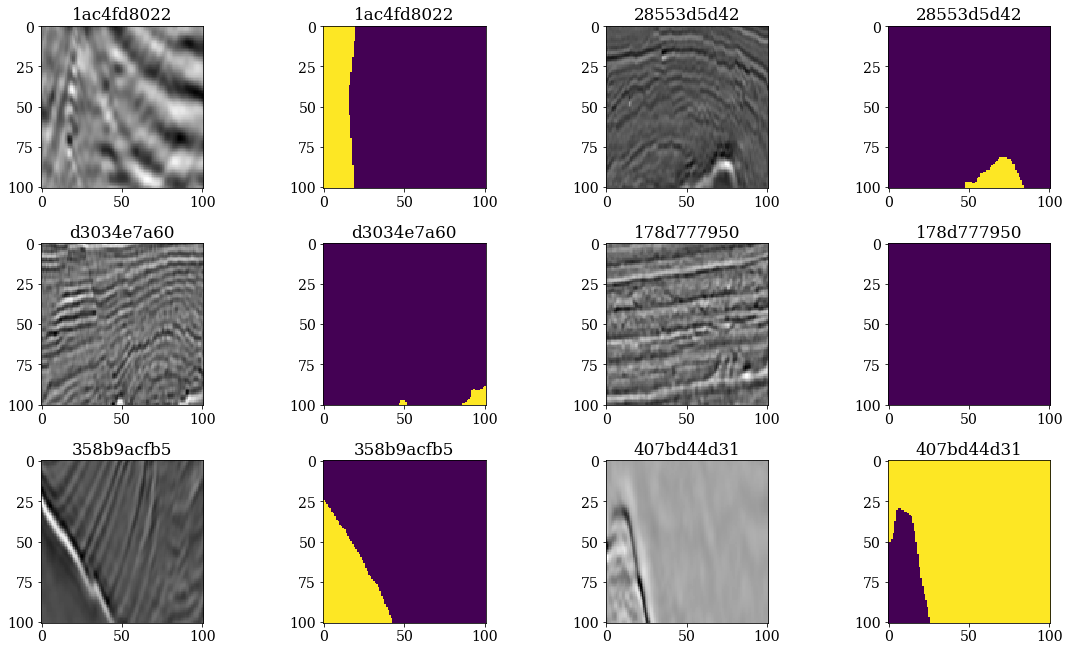

In [10]:
plt.rc('font', family='serif')
plt.rc('font', size=14)

images_to_plot = 6
indices = np.random.randint(0, len(train_images)-1, size=(images_to_plot,))

n_cols = 4
n_rows = np.ceil(2 * images_to_plot / n_cols) + 1

fig = plt.figure( figsize=(4*n_cols, 3*n_rows) )

for i, index in enumerate(indices):
    ax = fig.add_subplot(n_rows, n_cols, 2*i+1)
    ax.imshow(train_images[index])
    ax.set_title(train_ids[index])
    
    ax = fig.add_subplot(n_rows, n_cols, 2*i+2)
    ax.imshow(train_masks[index])
    ax.set_title(train_ids[index])

fig.tight_layout()

### Resize Images/Masks
I am going to upscale the images to `(128,128)` for training of the U-Net.  Quickly plot for reference.

In [11]:
upscale = lambda x: resize(x, (RESIZED_WIDTH, RESIZED_HEIGHT, 1), anti_aliasing=False)
train_df['image'] = train_df['image'].apply(upscale)
train_df['mask'] = train_df['mask'].apply(upscale)

In [12]:
print('The training images have shape {}.'.format(train_df['image'][0].shape))
print('The training masks have shape {}.'.format(train_df['mask'][0].shape))

The training images have shape (128, 128, 1).
The training masks have shape (128, 128, 1).


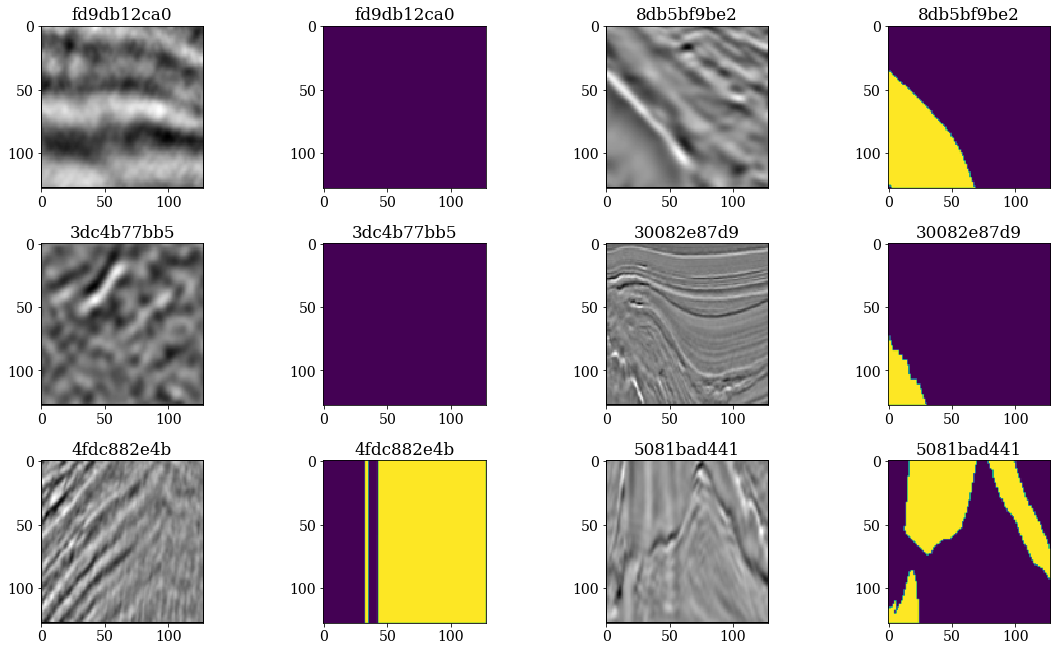

In [13]:
images_to_plot = 6
indices = np.random.randint(0, len(train_images)-1, size=(images_to_plot,))

n_cols = 4
n_rows = np.ceil(2 * images_to_plot / n_cols) + 1

fig = plt.figure( figsize=(4*n_cols, 3*n_rows) )

for i, index in enumerate(indices):
    ax = fig.add_subplot(n_rows, n_cols, 2*i+1)
    ax.imshow(train_df['image'].values[index][:,:,0], cmap='gray')
    ax.set_title(train_ids[index])
    
    ax = fig.add_subplot(n_rows, n_cols, 2*i+2)
    ax.imshow(train_df['mask'].values[index][:,:,0])
    ax.set_title(train_ids[index])

fig.tight_layout()

### Prepare Dataset 
Now I am going to setup the training and validation datasets. Here one could add stratification by depth or salt fraction. 

In [14]:
x_train, x_valid, y_train, y_valid = train_test_split(
    np.array(train_df['image'].values.tolist()).reshape(-1, RESIZED_WIDTH, RESIZED_HEIGHT, 1), 
    np.array(train_df['mask'].values.tolist()).reshape(-1, RESIZED_WIDTH, RESIZED_HEIGHT, 1),
    test_size=0.2)

### Build Network 
Now that the training data is in acceptable shape, let's construct the network.  For this, I am using the Keras package and following the architecture that was used in the following kernel.  This is a standard UNet.
https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification

In [15]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    #pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    #pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    #uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    #uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    #uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    #uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [16]:
input_layer  = Input((RESIZED_WIDTH, RESIZED_HEIGHT, 1))
output_layer = build_model(input_layer, start_neurons=4)

# Build the model. 
unet = Model(input_layer, output_layer)
unet.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 4)  40          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 4)  148         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 4)    0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [51]:
def build_jesper_net():
    # Build U-Net model
    inputs = Input((RESIZED_HEIGHT, RESIZED_WIDTH, IMAGE_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (s)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model 

### Debugging
This network that I created isn't working properly.  To test my dataset I am inserting one that is known to work.

In [52]:
jesper_net = build_jesper_net()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 1)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 16) 160         lambda_2[0][0]                   
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_39[0][0]                  
__________________________________________________________________________________________________
max_poolin

### Train the Net
Here I am using early stopping.

In [53]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("../models/v1.0.unet", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 100
batch_size = 32

#history = unet.fit(x_train, y_train,
#                    validation_data=[x_valid, y_valid], 
#                    epochs=epochs,
#                    batch_size=batch_size,
#                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

history = jesper_net.fit(x_train, y_train, 
                   validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Train on 3200 samples, validate on 800 samples
Epoch 1/100
3200/3200 [==============================] - 10s 3ms/step - loss: 0.0744 - acc: 0.7382 - val_loss: 5.8355e-05 - val_acc: 0.7583

Epoch 00001: val_loss improved from inf to 0.00006, saving model to ../models/v1.0.unet
Epoch 2/100
3200/3200 [==============================] - 8s 3ms/step - loss: 6.1519e-05 - acc: 0.7457 - val_loss: 5.8355e-05 - val_acc: 0.7583

Epoch 00002: val_loss did not improve from 0.00006
Epoch 3/100
3200/3200 [==============================] - 8s 3ms/step - loss: 6.1519e-05 - acc: 0.7457 - val_loss: 5.8355e-05 - val_acc: 0.7583

Epoch 00003: val_loss did not improve from 0.00006
Epoch 4/100
3200/3200 [==============================] - 8s 3ms/step - loss: 6.1519e-05 - acc: 0.7457 - val_loss: 5.8355e-05 - val_acc: 0.7583

Epoch 00004: val_loss did not improve from 0.00006
Epoch 5/100
3200/3200 [==============================] - 8s 3ms/step - loss: 6.1519e-05 - acc: 0.7457 - val_loss: 5.8355e-05 - val_acc: 0.7

### Plot Training History
Using the Keras training return value, we will have a look at the training and validation loss.

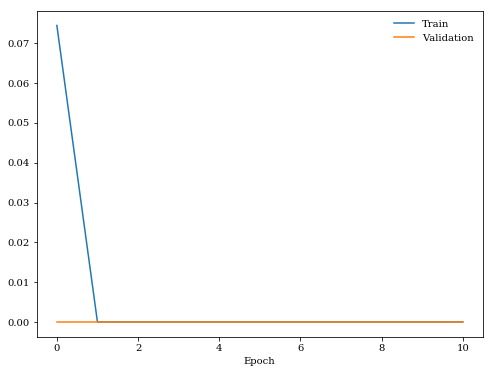

In [54]:
fig = plt.figure( figsize=(8,6) )
ax = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'], label='Train')
ax.plot(history.history['val_loss'], label='Validation')
ax.set_xlabel('Epoch')
ax.legend(frameon=False)

In [55]:
model = load_model('../models/v1.0.unet')

### Predict the Training Set
By predicting the validation set, an inspection of the predictions can be made.

In [56]:
y_pred = model.predict(x_valid)

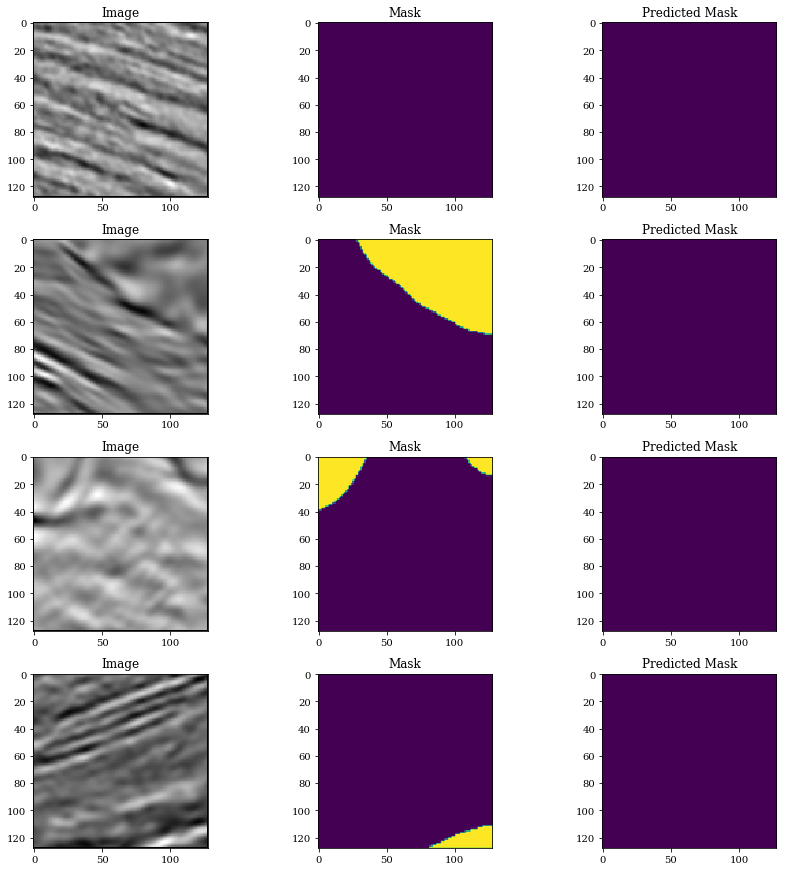

In [57]:
images_to_plot = 4
indices = np.random.randint(0, y_pred.shape[0]-1, size=(images_to_plot,))

n_cols = 3
n_rows = np.ceil(3 * images_to_plot / n_cols) + 1

fig = plt.figure( figsize=(4*n_cols, 3*n_rows) )

for i, index in enumerate(indices):
    ax = fig.add_subplot(n_rows, n_cols, 3*i+1)
    ax.imshow(x_valid[index, :, :, 0], cmap='gray')
    ax.set_title('Image')
    
    ax = fig.add_subplot(n_rows, n_cols, 3*i+2)
    ax.imshow(y_valid[index, :, :, 0])
    ax.set_title('Mask')
        
    ax = fig.add_subplot(n_rows, n_cols, 3*i+3)
    ax.imshow(y_pred[index, :, :, 0])
    ax.set_title('Predicted Mask')
    
fig.tight_layout()

### Predict the Testing Set
First the model is loaded, then the testing set.

In [20]:
test_ids = [id for id in depth_df['id'].values if id not in train_df['id'].values]
print('Found {} testing id numbers.'.format(len(test_ids)))

Found 18000 testing id numbers.


In [21]:
test_df = pd.DataFrame({'id':test_ids})
test_df.head()

,id
0,353e010b7b
1,5439dbbddf
2,71bab9f311
3,52551f7a80
4,512d8d9997


In [22]:
test_images = [imread('{}test/images/{}.png'.format(BASE_DIRECTORY, id)) / 255.0 for id in test_ids]
test_df['image'] = test_images
test_df['image'] = test_df['image'].apply(upscale)

In [23]:
x_test = np.array(test_df['image'].values.tolist()).reshape(-1, RESIZED_WIDTH, RESIZED_HEIGHT, 1)
print('Testing data ready for prediction with shape {}'.format(x_test.shape))

Testing data ready for prediction with shape (18000, 128, 128, 1)


In [24]:
y_pred = model.predict(x_test)

In [25]:
test_df['mask'] = [y for y in y_pred]
test_df.head()

,id,image,mask
0,353e010b7b,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[0.025158778], [0.0021980237], [0.0002400855..."
1,5439dbbddf,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[2.5352423e-07], [7.850619e-12], [6.57241e-1..."
2,71bab9f311,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[5.693473e-08], [6.295681e-13], [2.0686912e-..."
3,52551f7a80,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[1.7678277e-08], [8.796074e-14], [1.4070268e..."
4,512d8d9997,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[4.3143692e-07], [1.9180522e-11], [2.216812e..."


In [26]:
downscale = lambda x: resize(x, (IMAGE_WIDTH, IMAGE_HEIGHT, 1), anti_aliasing=False)
test_df['mask'] = test_df['mask'].apply(downscale)

In [27]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

### To Do
- Clean up this section of the notebook.
- Add smart threshold finding based on validation set. 
- Parallel apply below (the encoding is slow)

In [28]:
test_df['mask'] = test_df['mask'].apply(lambda x: np.round(x > 0.5))
test_df['rle_mask'] = test_df['mask'].apply(RLenc)

In [29]:
test_df.head(16)

,id,image,mask,rle_mask
0,353e010b7b,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",
1,5439dbbddf,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",
2,71bab9f311,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",
3,52551f7a80,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",
4,512d8d9997,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",
5,64dba827d6,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",
6,0a3a8a5f37,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",
7,329563756f,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",
8,f6cba2e890,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",
9,989c646373,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",


In [30]:
test_df[['id', 'rle_mask']].to_csv('../data/submissions/v1.0-unet.csv', index=False)